## Maximum  Covering Location Problem (MBCLP) solved by Genetic Algorithm (GA)

In [1]:
from Algorithm.GA import display_points_with_mclp, GeneticAlgorithm
import random
import numpy as np
from matplotlib import pyplot as plt

## Load the real-world datasets

In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


## Load demand point

In [4]:
%%time
# 读取相对路径下的需求点数据
ls = gpd.read_file("./data/data/real/福田区car-share/demand.shp")
ls['POINT_X'] = ls.geometry.x
ls['POINT_Y'] = ls.geometry.y
ls.head(2)

Wall time: 327 ms


,demand,POINT_X,POINT_Y,geometry
0,0.071082,813513.945347,2.491772e+06,POINT (813513.945 2491772.476)
1,0.070170,813713.945347,2.491772e+06,POINT (813713.945 2491772.476)


In [5]:
def normalize_to_1_10(data):
    """
    将一组数据归一化到1-10
    """
    min_val = min(data)
    max_val = max(data)
    normalized_data = [(x - min_val) / (max_val - min_val) * 9 + 1 for x in data]
    return normalized_data

# times -1 for maximizing the sum
# ls['speed_pct_freeflow_rev'] = ls.pct_from_f * (-1)

ls['demand_normalized'] = normalize_to_1_10(ls['demand'])

# total_pop = sum(ls['demand'])
# total_pop_norm = sum(ls['speed_pct_freeflow_rev_norm'])
# print("The number of records is ", len(ls))
# print("The total speed unit are ", total_pop)
# print("The total norm speed unit are ", total_pop_norm)

## Load facilities points

In [6]:
#读取设施点数据
sitedf = gpd.read_file("./data/data/real/福田区car-share/sheshidian.shp")
# sitedf = pd.read_csv("./data/real/billboards_nyc.csv")
# sites = np.array(sitedf[['NORM_X', 'NORM_Y']], dtype=np.float64)
print("The number of billboards in Seattle area is ", len(sitedf))
sitedf.head(2)

The number of billboards in Seattle area is  159


,name,wgs84_lng,wgs84_lat,ad,POINT_X,POINT_Y,geometry
0,城联物流大厦停车场,114.05122954110132,22.504835668206958,福田区,813929.210967,2.491908e+06,POINT (813929.211 2491908.493)
1,福星惠誉大楼停车场,114.0453673944444,22.506250001610663,福田区,813322.481139,2.492053e+06,POINT (813322.481 2492052.905)


## Normalization

In [7]:
def Normalization(x, y):
    max_x, max_y = np.max(x), np.max(y)
    min_x, min_y = np.min(x), np.min(y)
    S_x = (max_x-min_x)
    S_y = (max_y-min_y)
    S = max(S_x, S_y)
    new_x, new_y = (x-min_x)/S, (y-min_y)/S
    data_xy = np.vstack((new_x, new_y))
    Data = data_xy.T
    return new_x, new_y, S

In [8]:
ls_X = np.array(ls['POINT_X'])
ls_Y = np.array(ls['POINT_Y'])
bbs_X = np.array(sitedf['POINT_X'])
bbs_Y = np.array(sitedf['POINT_Y'])
X = np.concatenate([ls_X, bbs_X])
Y = np.concatenate([ls_Y, bbs_Y])
NORM_X, NORM_Y, S = Normalization(X, Y)
ls['NORM_X'] = NORM_X[:len(ls)]
ls['NORM_Y'] = NORM_Y[:len(ls)]
sitedf['NORM_X'] = NORM_X[len(ls):]
sitedf['NORM_Y'] = NORM_Y[len(ls):]

In [9]:
def generate_candidate_sites(sites, M=100, heuristic = None):
    '''
    Generate M candidate sites with the convex hull of a point set
    Input:
        sites: a Pandas DataFrame with X, Y and other characteristic
        M: the number of candidate sites to generate
        heuristic:
    Return:
        sites: a Numpy array with shape of (M,2)
    '''

    if M is not None:
        if M > len(sites):
            M = None
    if heuristic is None or heuristic == '':
        if M is None:
            return sites
        np.random.seed(0)
        index = np.random.choice(len(sites), M)
        return sites.iloc[index]
    elif heuristic == 'coverage':
        sites = sites.sort_values(by='pop_covered_2km', ascending=False).reset_index()
        if M is None:
            return sites
        return sites.iloc[:M]
    elif heuristic == 'coverage_e':
        sites = sites.sort_values(by='pop_covered_2km_exclusive', ascending=False).reset_index()
        if M is None:
            return sites
        return sites.iloc[:M]
    elif heuristic == 'impression':
        sites = sites.sort_values(by='weeklyImpr', ascending=False).reset_index()
        if M is None:
            return sites
        return sites.iloc[:M]
    elif heuristic == 'impression_e':
        sites = sites.sort_values(by='weeklyImpr_2km_exclusive', ascending=False).reset_index()
        if M is None:
            return sites
        return sites.iloc[:M]

In [10]:
bbs_ = generate_candidate_sites(sitedf, M=None, heuristic="")

# Data Convert

In [11]:
users = np.array(ls[['NORM_X', 'NORM_Y']])
facilities = np.array(bbs_[['NORM_X', 'NORM_Y']])
demand = np.array(ls['demand'])
p = 30
real_radius = 500
radius = real_radius/S

dist = np.sum((facilities[:, np.newaxis, :] - users[np.newaxis, :, :]) ** 2, axis=-1) ** 0.5
A = np.sum((facilities[:, np.newaxis, :] - users[np.newaxis, :, :]) ** 2, axis=-1) ** 0.5
mask1 = A <= radius
A[mask1] = 1
A[~mask1] = 0

In [12]:
%time
# start = time.time()
genetic = GeneticAlgorithm(len(ls), len(bbs_), p, dist, radius, demand)
genetic.optimize()
# end = time.time()-start
# print(end)
obj = np.sum(demand) - genetic.top_chromosome.fitness
centers = genetic.top_chromosome.content

print("The Set of centers are: %s" % centers)
print("The objective is: %s" % str(round(obj)))

Wall time: 0 ns
Current top solution: [114, 74, 83, 2, 143, 109, 19, 75, 111, 54, 32, 129, 49, 144, 18, 4, 27, 89, 151, 134, 142, 121, 35, 59, 67, 140, 130, 63, 45, 50] f=403

Final top solution: [34, 133, 47, 32, 89, 125, 25, 22, 50, 55, 61, 24, 88, 144, 114, 105, 116, 79, 58, 15, 121, 84, 70, 35, 56, 19, 48, 66, 96, 128] f=351
Time: 00:00:1.9208
The Set of centers are: [34, 133, 47, 32, 89, 125, 25, 22, 50, 55, 61, 24, 88, 144, 114, 105, 116, 79, 58, 15, 121, 84, 70, 35, 56, 19, 48, 66, 96, 128]
The objective is: 258


In [13]:
objs = []
for i in range(1):
    genetic = GeneticAlgorithm(len(ls), len(bbs_), p, dist, radius, demand)
    genetic.optimize()
    obj = np.sum(demand) - genetic.top_chromosome.fitness
    objs.append(obj)
mean_obj = np.mean(objs)
print("The mean objective is: %s" % str(round(obj)))

Current top solution: [66, 116, 41, 74, 35, 33, 17, 115, 36, 79, 12, 50, 139, 150, 141, 158, 112, 85, 134, 133, 132, 119, 78, 109, 113, 28, 24, 92, 37, 20] f=387

Final top solution: [28, 85, 32, 61, 25, 105, 93, 86, 42, 114, 135, 17, 120, 138, 133, 60, 127, 33, 119, 19, 77, 81, 51, 134, 66, 147, 79, 49, 109, 18] f=351
Time: 00:00:1.9139
The mean objective is: 258


In [50]:
def plot_result(ls, opt_sites, radius):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Pandas DataFrame
        radius: the radius of circle
    '''
    fig, ax = plt.subplots(figsize=(20, 15))
    ls.plot(ax=ax, column=ls['demand_normalized'], k=5, markersize=5, cmap='Blues', label='Demand Points')
    legend_plot_flag = {'current': False, 'selected': False}

    for cnt, site in opt_sites.iterrows():
        if 'current' in opt_sites.columns and site['current'] == True:  #ncurrent
            if legend_plot_flag['current'] == False:
                ax.scatter(site['POINT_X'], site['POINT_Y'], c='red', marker='+', s=10, label='Current Billboards')
                circlelabel = 'Service Range for Current Billboards'
                legend_plot_flag['current'] = True
            ax.scatter(site['POINT_X'], site['POINT_Y'], c='red', marker='+', s=100)
            #             circle = plt.Circle(site[['POINT_X','POINT_Y']], radius, color='red', fill=False, lw=2, label = circlelabel)
            circle = plt.Circle(site[['POINT_X', 'POINT_Y']], radius, color='red', fill=False, lw=2)

            ax.add_artist(circle)
        else:
            if legend_plot_flag['selected'] == False:
                ax.scatter(site['POINT_X'], site['POINT_Y'], c='C1', marker='+', s=20,
                           label='Optimized Selected Cars')
                circlelabel = 'Service Range for Optimized Selected Cars'
                legend_plot_flag['selected'] = True
            ax.scatter(site['POINT_X'], site['POINT_Y'], c='C1', marker='+', s=100)
            #             circle = plt.Circle(site[['POINT_X','POINT_Y']], radius, color='C1', fill=False, lw=2, label = circlelabel)
            circle = plt.Circle(site[['POINT_X', 'POINT_Y']], radius, color='C1', fill=False, lw=2)
            ax.add_artist(circle)

    ax.axis('scaled')
    ax.tick_params(axis='both', left=False, top=False, right=False,
                   bottom=False, labelleft=False, labeltop=False,
                   labelright=False, labelbottom=False)
    title = 'Selected ' + str(len(opt_sites)) + ' Sites that Serve ' + str(radius) + ' m by GA '
    ax.set_title(title, fontsize=40)
    render_scale_bar(ax=ax, x=0.05, y=0.05)
    render_north_arrow(ax=ax, x=0.95, y=0.95, size=0.01, ratio=0.7)
    ax.legend(loc='lower right', markerscale=4, fontsize=20)
    return ax

In [51]:
def render_scale_bar(ax, x, y, segments=2, height=0.01, seg_length=2000, unit='m', linewidth=1.):
    unit_scale_factor = {
        'm': 1,
        'km': 1000,下·
        'meters': 1,
        'kilometers': 1000,
        'miles': 1609.34,
        'mi': 1609.34,
        'ft': 0.3,
        }
    x_lim = ax.get_xlim()
    y_lim = ax.get_ylim()

    # how much percent does one unit takes on the x axis
    x_per_unit = 1. / (x_lim[1] - x_lim[0])
    y_per_unit = 1. / (y_lim[1] - y_lim[0])

    # base for ticks (0, 1)
    x_base = [x + seg_length * unit_scale_factor[unit] * x_per_unit * i for i in range(0, segments + 1)]
    ax.axhline(y_lim[0] + y / y_per_unit, x_base[0], x_base[-1], c='black')
    y_base = [y, y + height]
    for i in range(segments + 1):
        ax.axvline(x_lim[0] + x_base[i] / x_per_unit, y, y + height, c='black')
        xy = (x_lim[0] + x_base[i] / x_per_unit, y_lim[0] + (y - 0.015) / y_per_unit)  # data_coords
        ax.text(xy[0], xy[1], s='{}'.format(int(seg_length * i)), horizontalalignment='center', verticalalignment='center')
    ax.text(x_lim[0] + (x_base[-1] + 0.02) / x_per_unit, y_lim[0] + (y - 0.015) / y_per_unit,
            s=unit, horizontalalignment='left',
            verticalalignment='center')
def render_north_arrow(ax, x, y, size, ratio = 1):
    path = [(0, 1), (-ratio, -1), (0, -0.5), (ratio, -1), (0, 1)]
    path = [(i[0] * size + x, i[1] * size + y) for i in path]
    arrow = plt.Polygon(path, color='black', transform=ax.transAxes)
    ax.add_patch(arrow)
    ax.text(x, y-size*2, s = 'N', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

SyntaxError: invalid syntax (3986181808.py, line 5)

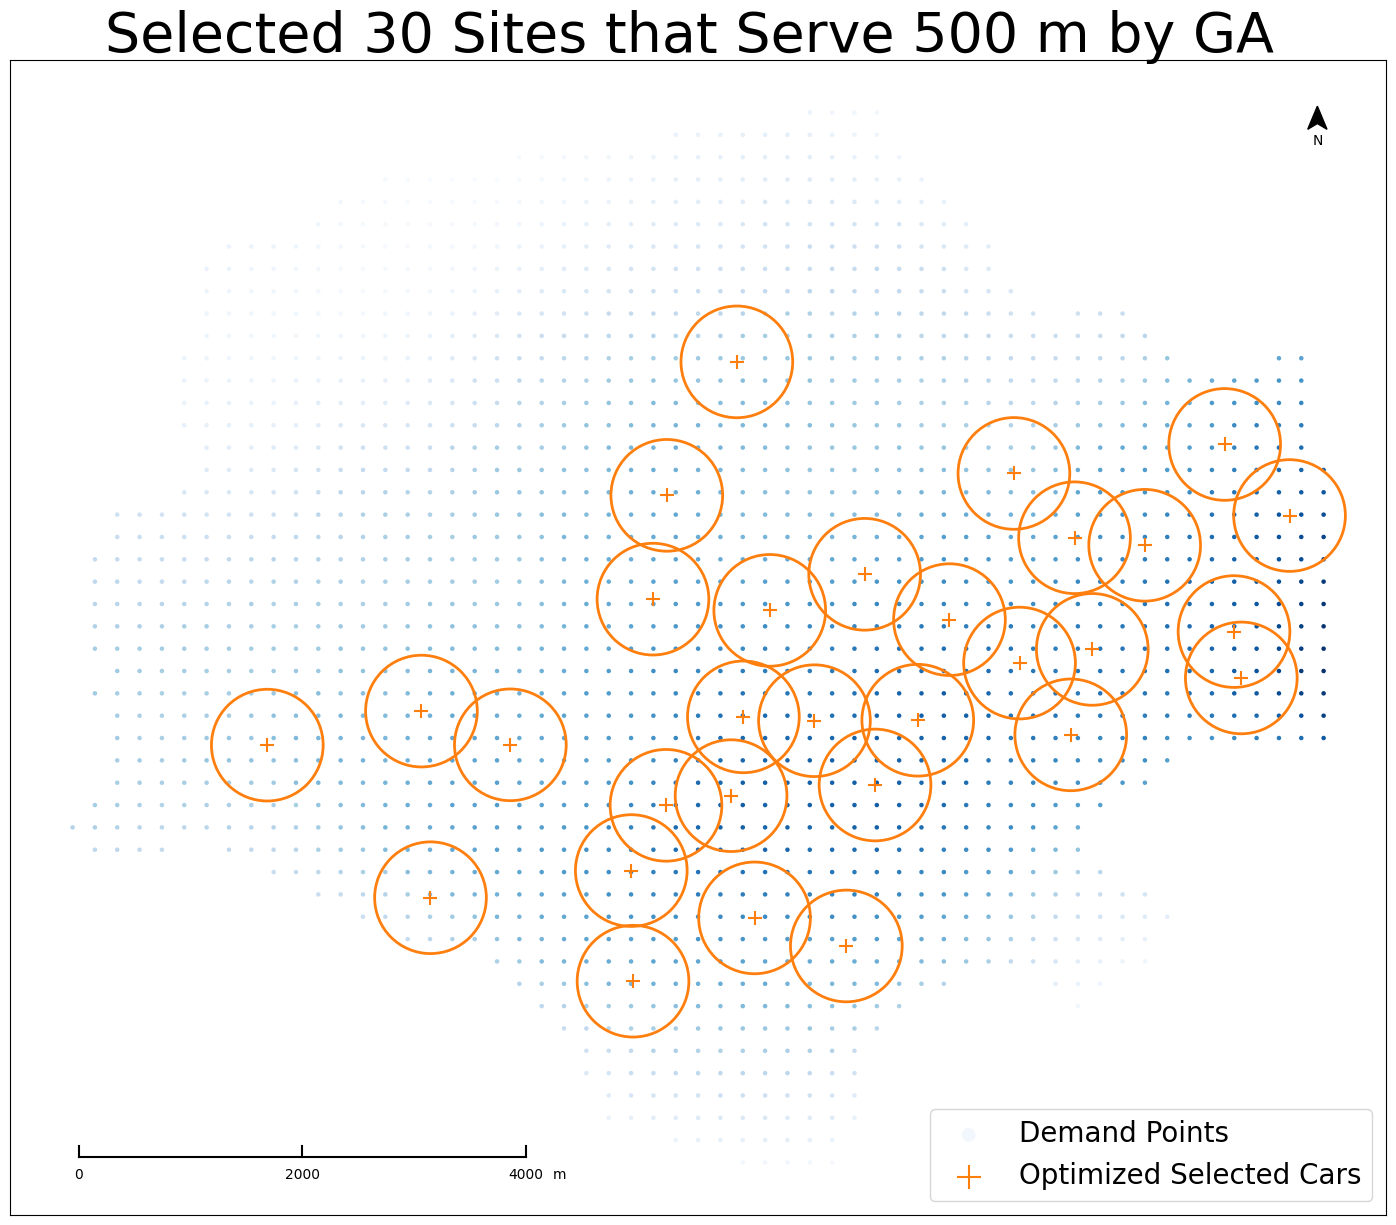

In [52]:
opt_sites = bbs_.iloc[centers]
plot_result(ls,opt_sites,real_radius)
plt.savefig('./picture/GA_MCLP.jpg', dpi=600)
plt.show()